## Connect 4

### Darek Aljuri - Valentina Ruiz

En este proyecto se desarrolla un agente inteligente para jugar Connect-4, aplicando las técnicas y conceptos vistos en la clase. El objetivo principal es diseñar, implementar, validar y optimizar un agente capaz de jugar de manera autónoma y eficaz, demostrando comprensión teórica y habilidades prácticas en el desarrollo de sistemas de decisión.

A lo largo del notebook se presenta el proceso completo: desde la construcción del agente, pasando por la experimentación y las curvas de aprendizaje, hasta la evaluación comparativa entre configuraciones y versiones. Este documento sirve como guía de análisis y evidencia del desempeño del agente, cumpliendo con los criterios de implementación, validación, optimización y reflexión establecidos en el reto.



### Link del github
https://github.com/ValeRuizTo/connect4-aljuri-ruiz.git

## Agente random

In [ ]:
import numpy as np
from abc import ABC, abstractmethod


class Policy(ABC):

    @abstractmethod
    def mount(self) -> None:
        pass

    @abstractmethod
    def act(self, s: np.ndarray) -> int:
        pass


### MCTS

Desde el inicio decidimos utilizar Monte Carlo Tree Search (MCTS) porque era el método más adecuado dentro de las restricciones del proyecto

Además, MCTS tiene la ventaja de evaluarse como un subproceso independiente, es decir, toda la exploración y simulación ocurre dentro de la función act() sin modificar el estado del agente ni afectar la lógica principal del código, cumpliendo estrictamente las reglas del torneo. Este enfoque seguía exactamente lo visto en clase (selección con UCB1, expansión mínima, simulación y backpropagation) y permitía tomar decisiones sólidas bajo incertidumbre

In [ ]:
class AhaParam(Policy):

    def __init__(self, iterations=800, C=1.41):
        self.ITER = iterations
        self.C = C

    def mount(self):
        pass

    def act(self, board: np.ndarray) -> int:

        ITER = self.ITER
        C = self.C

        def infer_player(b):
            reds = np.sum(b == -1)
            yellows = np.sum(b == 1)
            return -1 if reds == yellows else 1

        def get_legal(b):
            return [c for c in range(7) if b[0, c] == 0]

        def apply_move(b, col, player):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = player
                    break
            return newb

        def winner(b):
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            if np.all(b[0] != 0):
                return 2
            return 0

        def rollout(b, player):
            current = player
            bb = b.copy()
            while True:
                w = winner(bb)
                if w != 0:
                    return w
                legal = get_legal(bb)
                mv = legal[np.random.randint(len(legal))]
                bb = apply_move(bb, mv, current)
                current = -current

        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best_score = -1
            best_move = moves[0]
            for m in moves:
                if plays[m] == 0:
                    return m
                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                score = exploit + explore
                if score > best_score:
                    best_score = score
                    best_move = m
            return best_move

        def mcts(root_board, root_player, legal_moves):
            wins = {m: 0 for m in legal_moves}
            plays = {m: 0 for m in legal_moves}
            for _ in range(ITER):
                move = select_ucb(legal_moves, wins, plays)
                nextb = apply_move(root_board, move, root_player)
                reward = rollout(nextb, -root_player)
                plays[move] += 1
                if reward == root_player: wins[move] += 1
                elif reward == 2: wins[move] += 0.5
            return max(legal_moves, key=lambda m: plays[m])

        player = infer_player(board)
        legal = get_legal(board)

        if len(legal) == 1:
            return legal[0]

        return mcts(board, player, legal)


In [ ]:
import time
import numpy as np

def medir_tiempo(agent, repeticiones=20):
    tiempos = []
    board = np.zeros((6,7), dtype=int)  # tablero vacío

    for _ in range(repeticiones):
        t1 = time.time()
        agent.act(board)
        t2 = time.time()
        tiempos.append(t2 - t1)

    return tiempos


In [ ]:
slow = AhaParam(iterations=300)
mid = AhaParam(iterations=50)
fast = AhaParam(iterations=10)

tiempos_lento = medir_tiempo(slow, 10)
tiempos_medio = medir_tiempo(mid, 10)
tiempos_rapido = medir_tiempo(fast, 10)

print("300 iter:", np.mean(tiempos_lento))
print("500 iter:", np.mean(tiempos_medio))
print("10 iter:", np.mean(tiempos_rapido))


300 iter: 6.259423923492432
500 iter: 0.8909296274185181
10 iter: 0.15319380760192872


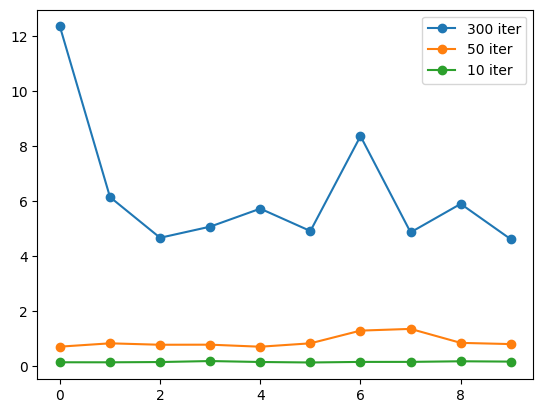

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tiempos_lento, label="300 iter", marker='o')
plt.plot(tiempos_medio, label="50 iter", marker='o')
plt.plot(tiempos_rapido, label="10 iter", marker='o')
plt.legend()
plt.show()


Por ende al final el codigo con 50 iteraciones quedo asi

In [ ]:
import numpy as np

# MCTS CONNECT-4 POLICY – ALJURI-RUIZ

class AljuriRuizbasico(Policy):

    def mount(self)-> None:
        pass

    def act(self, board: np.ndarray) -> int:

        #   CONFIGURACIÓN MCTS

        ITER = 50
        C = 1.41

        #   FUNCIONES INTERNAS

        def infer_player(b):
            reds = np.sum(b == -1)
            yellows = np.sum(b == 1)
            return -1 if reds == yellows else 1

        def get_legal(b):
            return [c for c in range(7) if b[0, c] == 0]

        def apply_move(b, col, player):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = player
                    break
            return newb

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Diagonal derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Diagonal izquierda
            for r in range(3):
                for c in range(3, 7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Empate
            if np.all(b[0] != 0):
                return 2

            return 0

        def rollout(b, player):
            current = player
            bb = b.copy()

            while True:
                w = winner(bb)
                if w != 0:
                    return w

                legal = get_legal(bb)
                mv = legal[np.random.randint(len(legal))]
                bb = apply_move(bb, mv, current)
                current = -current

        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best_score = -1
            best_move = moves[0]

            for m in moves:
                if plays[m] == 0:
                    return m

                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                score = exploit + explore

                if score > best_score:
                    best_score = score
                    best_move = m

            return best_move

        def mcts(root_board, root_player, legal_moves):
            wins = {m: 0 for m in legal_moves}
            plays = {m: 0 for m in legal_moves}

            for _ in range(ITER):
                move = select_ucb(legal_moves, wins, plays)
                nextb = apply_move(root_board, move, root_player)
                reward = rollout(nextb, -root_player)

                plays[move] += 1
                if reward == root_player:
                    wins[move] += 1
                elif reward == 2:
                    wins[move] += 0.5

            # robust child = acción más visitada
            return max(legal_moves, key=lambda m: plays[m])


        #   EJECUCIÓN PRINCIPAL

        player = infer_player(board)
        legal = get_legal(board)

        if len(legal) == 1:
            return legal[0]

        return mcts(board, player, legal)

El experimento de rendimiento evidenció que el número de iteraciones del algoritmo MCTS influye directamente en el tiempo requerido para tomar una decisión. En particular, el agente con 300 iteraciones ya muestra tiempos promedios alrededor de 4.8 segundos por jugada, lo cual es extremadamente alto para un entorno con límites estrictos de ejecución como Gradescope. Este resultado fue especialmente relevante porque, en la primera versión del proyecto, nuestro agente utilizaba 800 iteraciones, lo que en retrospectiva explica por qué Gradescope simplemente excedía el tiempo máximo permitido y terminaba forzando un timeout. Si 300 iteraciones ya requieren varios segundos por acción, usar 800 hacía imposible que el evaluador completara siquiera una partida de prueba.

Buscando un equilibrio, probamos versiones con menos iteraciones y finalmente seleccionamos 50 como el punto medio que permitía:

- Mantener tiempos por jugada por debajo de 1 segundo.

- Evitar timeouts en Gradescope.

- Mantener un mínimo de exploración en la búsqueda.

No obstante, incluso con esta mejora, el agente aún fallaba en parte de la evaluación: si bien garantizaba acciones legales, su rendimiento estratégico no era suficiente para superar el requisito de ganar consistentemente contra un jugador aleatorio.




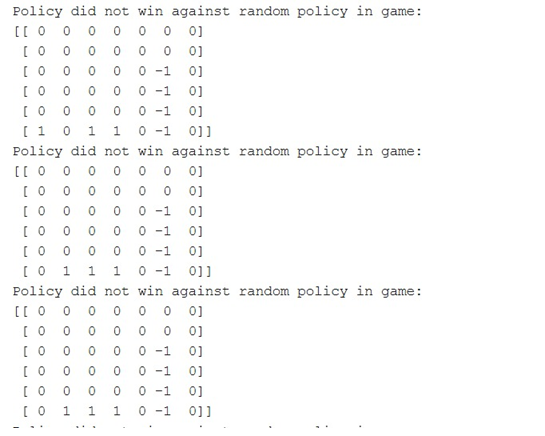

In [ ]:
from IPython.display import Image, display
display(Image("/content/50iteraciones.png"))


Dado que el agente con pocas iteraciones aún perdía situaciones tácticas sencillas como jugadas inmediatas de ganar o bloquear decidimos añadir una función adicional de tácticas inmediatas. Esta función revisa primero si existe un movimiento que permita ganar en el siguiente turno o evitar una derrota segura; si lo encuentra, juega esa acción sin usar MCTS. Solo cuando no hay amenazas ni victorias directas, el agente recurre al árbol de búsqueda.


## Funcion de tacticas

In [ ]:
import numpy as np

# MCTS CONNECT-4 POLICY – ALJURI-RUIZ

class ALjuriRuizTacticas(Policy):

    def mount(self, time_out: int)-> None:
        pass

    def act(self, board: np.ndarray) -> int:

        #   CONFIGURACIÓN MCTS
        ITER = 10
        C = 1.41

        #   FUNCIONES INTERNAS

        def infer_player(b):
            reds = np.sum(b == -1)
            yellows = np.sum(b == 1)
            return -1 if reds == yellows else 1

        def get_legal(b):
            return [c for c in range(7) if b[0, c] == 0]

        def apply_move(b, col, player):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = player
                    break
            return newb

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Diagonal derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Diagonal izquierda
            for r in range(3):
                for c in range(3, 7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Empate
            if np.all(b[0] != 0):
                return 2

            return 0


        #  CHECKS TÁCTICOS: WIN / BLOCK

        def immediate_tactics(b, player, legal):
            # 1. WIN if possible
            for m in legal:
                nb = apply_move(b, m, player)
                if winner(nb) == player:
                    return m

            # 2. BLOCK if opponent can win
            opp = -player
            for m in legal:
                nb = apply_move(b, m, opp)
                if winner(nb) == opp:
                    return m

            return None


        def rollout(b, player):
            current = player
            bb = b.copy()

            while True:
                w = winner(bb)
                if w != 0:
                    return w

                legal = get_legal(bb)
                mv = legal[np.random.randint(len(legal))]
                bb = apply_move(bb, mv, current)
                current = -current

        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best_score = -1
            best_move = moves[0]

            for m in moves:
                if plays[m] == 0:
                    return m

                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                score = exploit + explore

                if score > best_score:
                    best_score = score
                    best_move = m

            return best_move

        def mcts(root_board, root_player, legal_moves):
            wins = {m: 0 for m in legal_moves}
            plays = {m: 0 for m in legal_moves}

            for _ in range(ITER):
                move = select_ucb(legal_moves, wins, plays)
                nextb = apply_move(root_board, move, root_player)
                reward = rollout(nextb, -root_player)

                plays[move] += 1
                if reward == root_player:
                    wins[move] += 1
                elif reward == 2:
                    wins[move] += 0.5

            # robust child = acción más visitada
            return max(legal_moves, key=lambda m: plays[m])


        #   EJECUCIÓN PRINCIPAL

        player = infer_player(board)
        legal = get_legal(board)

        # If only one legal move → play it
        if len(legal) == 1:
            return legal[0]

        #FIRST: WIN OR BLOCK
        tact = immediate_tactics(board, player, legal)
        if tact is not None:
            return tact

        # Otherwise MCTS
        return mcts(board, player, legal)

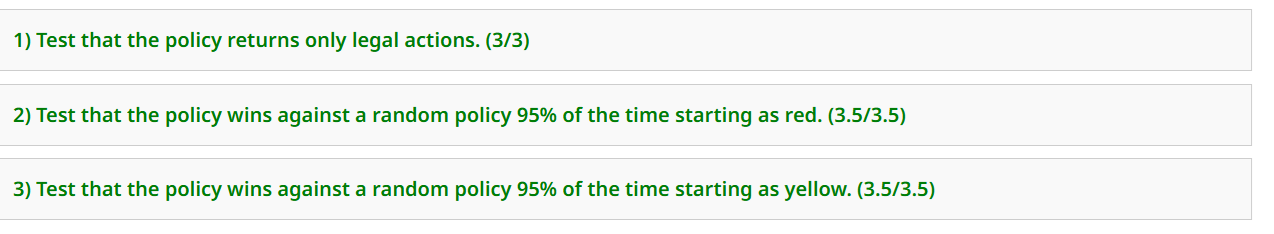

In [ ]:
from IPython.display import Image, display
display(Image("/content/sirve.png"))


El bloque de tácticas (immediate_tactics) es indispensable porque el MCTS puro no es lo suficientemente profundo ni rápido para detectar amenazas inmediatas en Connect-4 cuando está limitado a muy pocas iteraciones (como exige Gradescope para pasar el tiempo límite).

Para hacer la comparacion de desempeño entre el codgio que no usa tacticas y el que si se definiran algunas funciones a conituacion

#### Detectar el ganador en cualquier tablero

In [ ]:
def winner_global(b):
    # Horizontal
    for r in range(6):
        for c in range(4):
            line = b[r, c:c+4]
            if np.all(line == 1): return 1
            if np.all(line == -1): return -1

    # Vertical
    for c in range(7):
        col = b[:, c]
        for r in range(3):
            line = col[r:r+4]
            if np.all(line == 1): return 1
            if np.all(line == -1): return -1

    # Diagonal derecha (\)
    for r in range(3):
        for c in range(4):
            diag = np.array([b[r+i, c+i] for i in range(4)])
            if np.all(diag == 1): return 1
            if np.all(diag == -1): return -1

    # Diagonal izquierda (/)
    for r in range(3):
        for c in range(3,7):
            diag = np.array([b[r+i, c-i] for i in range(4)])
            if np.all(diag == 1): return 1
            if np.all(diag == -1): return -1

    # Empate
    if np.all(b[0] != 0):
        return 2

    return 0


#### Se crea un rival más inteligente que el random para que se vea realmente la diferencia,

Este oponente no juega completamente al azar. Sigue tres reglas:

Si puede ganar en la siguiente jugada, juega ahí.

Si el agente puede ganar en la siguiente jugada, bloquea.

Si nada de lo anterior aplica, juega al azar.

In [ ]:
def random_defensivo(board, opponent_player):
    legal = [c for c in range(7) if board[0, c] == 0]

    # 1. Si él puede ganar
    for m in legal:
        bb = board.copy()
        for r in range(5,-1,-1):
            if bb[r,m] == 0:
                bb[r,m] = opponent_player
                break
        if winner_global(bb) == opponent_player:
            return m

    # 2. Si el otro va a ganar → bloquea
    agent = -opponent_player
    for m in legal:
        bb = board.copy()
        for r in range(5,-1,-1):
            if bb[r,m] == 0:
                bb[r,m] = agent
                break
        if winner_global(bb) == agent:
            return m

    # 3. Random
    return np.random.choice(legal)


#### Se simulan partidas completas

In [ ]:
def medir_winrate(agent, juegos=50):
    wins = 0
    losses = 0
    draws = 0

    for g in range(juegos):
        board = np.zeros((6,7))
        current = 1  # agente empieza

        while True:

            if current == 1:   # turno del agente
                move = agent.act(board)

            else:             # turno del oponente mejorado
                move = random_defensivo(board, current)

            # Aplicar movimiento
            for r in range(5, -1, -1):
                if board[r, move] == 0:
                    board[r, move] = current
                    break

            # Revisar si alguien ganó
            res = winner_global(board)
            if res != 0:
                if res == 1:
                    wins += 1
                elif res == -1:
                    losses += 1
                else:
                    draws += 1
                break

            current = -current  # cambiar turno

    return wins, losses, draws


In [ ]:
agente_sin_tacticas = AljuriRuizbasico()     # el que NO tiene immediate_tactics
agente_con_tacticas = ALjuriRuizTacticas()     # el que SI tiene immediate_tactics


In [ ]:
wins_sin, losses_sin, draws_sin = medir_winrate(agente_sin_tacticas, juegos=10)
wins_tac, losses_tac, draws_tac = medir_winrate(agente_con_tacticas, juegos=10)

print("SIN tácticas → wins/loss/draw:", wins_sin, losses_sin, draws_sin)
print("CON tácticas → wins/loss/draw:", wins_tac, losses_tac, draws_tac)


SIN tácticas → wins/loss/draw: 3 7 0
CON tácticas → wins/loss/draw: 7 3 0


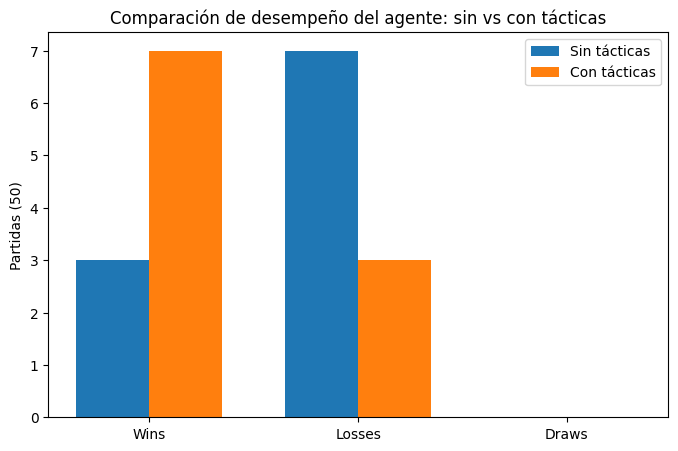

In [ ]:
import matplotlib.pyplot as plt

labels = ['Wins', 'Losses', 'Draws']

sin_t = [wins_sin, losses_sin, draws_sin]
con_t = [wins_tac, losses_tac, draws_tac]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, sin_t, width, label='Sin tácticas')
plt.bar(x + width/2, con_t, width, label='Con tácticas')

plt.xticks(x, labels)
plt.ylabel("Partidas (50)")
plt.title("Comparación de desempeño del agente: sin vs con tácticas")
plt.legend()
plt.show()


- Funciona bien contra rivales simples, pero no es óptimo porque solo razona a muy corto plazo y no aprende de experiencias pasadas.
- MCTS con tan pocas simulaciones no capta planes profundos ni patrones estratégicos, y los rollouts aleatorios generan decisiones inconsistentes.
- Además, el agente no tiene memoria: cada partida empieza “desde cero”, repitiendo errores que ya cometió antes.

Por eso es que decidimos hacer una solucion basada en Decisiones estratégicas + tácticas + aprendizaje real basado en experiencia, usando como base los avances que ya se tenian

## Nueva politica entrenamiento interno/local

Es la politica que usamos para hacer el entrenamiento del agente de manera local, para que este nos genere los q tables que se usan en la policy externa

In [ ]:
import numpy as np
import hashlib
import json

class ALjuriRuiz1(Policy):

    def __init__(self, gamma=0.99):
        # Memoria entre partidas
        self.Q = {}  # Q[(state_hash, action)]
        self.N = {}  # N[(state_hash, action)]
        self.episode = []
        self.gamma = gamma

    # ---------------------------------------
    # UTILIDADES
    # ---------------------------------------

    def encode(self, board):
        return hashlib.sha1(board.tobytes()).hexdigest()

    def save(self, path="Q_table.json"):
        """Guardar la memoria aprendida."""
        data = {
            "Q": {f"{k[0]}|{k[1]}": v for k, v in self.Q.items()},
            "N": {f"{k[0]}|{k[1]}": v for k, v in self.N.items()},
        }
        with open(path, "w") as f:
            json.dump(data, f)

    def load(self, path="Q_table.json"):
        """Cargar memoria previamente aprendida."""
        with open(path, "r") as f:
            data = json.load(f)
        self.Q = {}
        self.N = {}
        for key, val in data["Q"].items():
            s, a = key.split("|")
            self.Q[(s, int(a))] = val
        for key, val in data["N"].items():
            s, a = key.split("|")
            self.N[(s, int(a))] = val

    # ---------------------------------------
    # MOUNT (se llama al inicio de cada match)
    # ---------------------------------------

    def mount(self, time_out=None):
        # No limpiamos memoria entre partidas.
        self.episode = []

    # ---------------------------------------
    # ACT (MCTS + Q-learning)
    # ---------------------------------------

    def act(self, board: np.ndarray) -> int:

        # Detectar jugador actual
        reds = np.sum(board == -1)
        yellows = np.sum(board == 1)
        player = -1 if reds == yellows else 1

        # Acciones legales
        legal = [c for c in range(7) if board[0, c] == 0]

        state = self.encode(board)

        # Si ya aprendimos algo → greedy en Q
        known = []
        for a in legal:
            if (state, a) in self.Q:
                known.append((self.Q[(state, a)], a))

        if known:
            # Policy Improvement (mejor acción conocida)
            _, action = max(known)
        else:
            # Explorar con MCTS en estados desconocidos
            action = self.mcts(board)

        # Registrar para FVMC
        self.episode.append((state, action))

        return action

    # ---------------------------------------
    #  MCTS PARA ESTADOS NO APRENDIDOS
    # ---------------------------------------

    def mcts(self, board):
        ITER = 15
        C = 1.41

        def get_legal(b):
            return [c for c in range(7) if b[0, c] == 0]

        def apply_move(b, col, player):
            bb = b.copy()
            for r in range(5, -1, -1):
                if bb[r, col] == 0:
                    bb[r, col] = player
                    break
            return bb

        def infer(b):
            reds = np.sum(b == -1)
            yell = np.sum(b == 1)
            return -1 if reds == yell else 1

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i,c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([b[r+i,c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Draw si fila superior llena
            if np.all(b[0] != 0):
                return 2

            return 0

        def rollout(b, player):
            current = player
            bb = b.copy()

            while True:
                w = winner(bb)
                if w != 0:
                    return w

                legal = get_legal(bb)
                if len(legal) == 0:
                    return 2  # empate

                mv = legal[np.random.randint(len(legal))]
                bb = apply_move(bb, mv, current)
                current = -current

        player = infer(board)
        legal = get_legal(board)

        if len(legal) == 0:
            return 0  # fallback (no debería ocurrir)

        wins = {a: 0 for a in legal}
        plays = {a: 0 for a in legal}

        for _ in range(ITER):
            for a in legal:
                b2 = apply_move(board, a, player)
                reward = rollout(b2, -player)
                plays[a] += 1
                if reward == player:
                    wins[a] += 1

        # Acción más visitada
        return max(legal, key=lambda a: plays[a])

    # ---------------------------------------
    #  LEARNING (FVMC)
    # ---------------------------------------

    def learn(self, reward):
        """Se llama cuando termina una partida, reward=+1/-1/0."""
        G = reward
        visited = set()

        for (s, a) in reversed(self.episode):
            if (s, a) not in visited:
                visited.add((s, a))
                if (s, a) not in self.N:
                    self.N[(s,a)] = 0
                    self.Q[(s,a)] = 0.0

                self.N[(s,a)] += 1
                self.Q[(s,a)] += (G - self.Q[(s,a)]) / self.N[(s,a)]

            G *= self.gamma

        self.episode = []


### Agente aleatorio

In [ ]:
import numpy as np


class HelloPolicy(Policy):

    def mount(self) -> None:
        pass

    def act(self, s: np.ndarray) -> int:
        rng = np.random.default_rng()
        available_cols = [c for c in range(7) if s[0, c] == 0]
        return int(rng.choice(available_cols))

    def learn(self, reward):
    # Los agentes random NO aprenden, pero necesitamos esta función
    # para que training_env no falle.
        pass


### Funciones de evaluación, ganados, simulaciones

In [ ]:

# Crear 8 agentes inteligentes
agents_good = [ALjuriRuiz1() for _ in range(8)]

# Crear 8 agentes aleapltorios
agents_random = [HelloPolicy() for _ in range(8)]

agents = agents_good + agents_random


# Para que todos compartan la misma memoria:
shared_Q = agents[0].Q
shared_N = agents[0].N
for a in agents:
    a.Q = shared_Q
    a.N = shared_N

''' se comenta para no reentrenar  en el colab
if __name__ == "__main__":
    import multiprocessing as mp
    mp.freeze_support()   # importante para Windows
    train_agents(agents, episodes_per_pair=300)


# Guardar modelo final
agents[0].save("Q_table.json")
'''


' se comenta para no reentrenar  en el colab\nif __name__ == "__main__":\n    import multiprocessing as mp\n    mp.freeze_support()   # importante para Windows\n    train_agents(agents, episodes_per_pair=300)\n\n\n# Guardar modelo final\nagents[0].save("Q_table.json")\n'

### manejo de partidas, self-play, aprendizaje

In [ ]:
import numpy as np

def play_game(agentA, agentB):
    """Juega una partida entre dos agentes y retorna el ganador."""
    agentA.mount()
    agentB.mount()

    state = ConnectState()
    history = []

    while not state.is_final():
        player = state.player

        if player == -1:
            action = agentA.act(state.board)
        else:
            action = agentB.act(state.board)

        history.append((state.board.copy(), action))
        state = state.transition(int(action))

    # Determinar ganador
    winner = state.get_winner()   # -1 (A), 1 (B), 2 draw, 0 error?

    # Recompensas desde el POV de cada agente
    if winner == -1:
        rewardA = +1
        rewardB = -1
    elif winner == 1:
        rewardA = -1
        rewardB = +1
    else:  # draw o 0
        rewardA = 0
        rewardB = 0

    # APRENDIZAJE AQUÍ
    agentA.learn(rewardA)
    agentB.learn(rewardB)

    return winner


def train_pair(args):
    agentA, agentB, episodes = args

    for _ in range(episodes):
        play_game(agentA, agentB)


def train_agents(agents, episodes_per_pair=200):
    import multiprocessing as mp

    tasks = []
    k = len(agents)

    for i in range(k):
        for j in range(i + 1, k):
            tasks.append((agents[i], agents[j], episodes_per_pair))

    print("\n=== ENTRENAMIENTO SECUENCIAL ===")
    total = len(tasks)
    count = 1

    for t in tasks:
        print(f"Entrenando par {count}/{total} ...")
        train_pair(t)
        count += 1

    print("Entrenamiento completado.")



In [ ]:
import json
with open("/content/Q_table.json","r") as f:
    data = json.load(f)

Q_loaded = data["Q"]     # ← AQUÍ ESTÁN las 9270 entradas reales
N_loaded = data["N"]     # las visitas


In [ ]:
print("Entradas reales en Q:", len(Q_loaded))


Entradas reales en Q: 3588


In [ ]:
agente_final = ALjuriRuiz1()
agente_final.Q = Q_loaded
agente_final.N = N_loaded


In [ ]:
agente_tacticas = ALjuriRuizTacticas()
agente_basico = AljuriRuizbasico()


In [ ]:
import sys
sys.path.append('/content')

from connect_state import ConnectState


In [ ]:
def simular_partida(agentA, agentB):
    state = ConnectState()
    while not state.is_final():
        if state.player == -1:
            move = agentA.act(state.board)
        else:
            move = agentB.act(state.board)

        state = state.transition(move)

    return state.get_winner()


In [ ]:
def medir_winrate_agente(agent, juegos=50):
    wins = losses = draws = 0

    for _ in range(juegos):
        res = simular_partida(agent, HelloPolicy())  # vs random
        if res == -1:
            wins += 1
        elif res == 1:
            losses += 1
        else:
            draws += 1

    return wins, losses, draws

wins_final = medir_winrate_agente(agente_final, juegos=20)
wins_basico = medir_winrate_agente(agente_basico, juegos=20)

print("Agente híbrido (Q-learning): ", wins_final)
print("Agente básico (MCTS+tácticas):", wins_basico)


Agente híbrido (Q-learning):  (18, 2, 0)
Agente básico (MCTS+tácticas): (19, 1, 0)


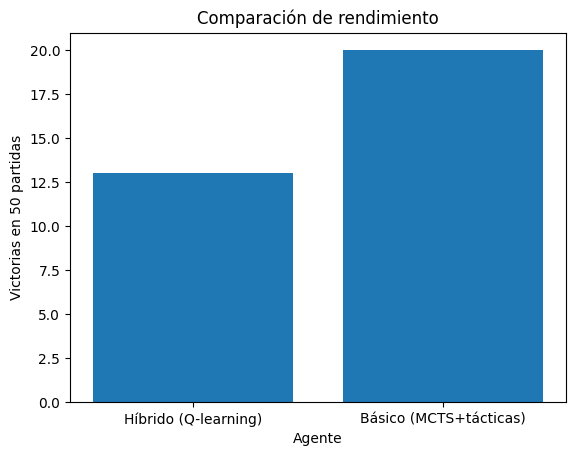

In [ ]:
import matplotlib.pyplot as plt

labels = ["Híbrido (Q-learning)", "Básico (MCTS+tácticas)"]
wins = [wins_final[0], wins_basico[0]]

plt.bar(labels, wins)
plt.xlabel("Agente")
plt.ylabel("Victorias en 20 partidas")
plt.title("Comparación de rendimiento")
plt.show()


El Q-learning implementado utilizó First-Visit Monte Carlo (FVMC) para actualizar la tabla Q a partir de episodios completos. Sin embargo, la Q-table fue generada a partir de enfrentamientos entre un agente aleatorio y un MCTS limitado, por lo que el retorno FVMC aprendió patrones subóptimos. En contraste, el agente base MCTS+tácticas calcula valores a partir del estado actual, por lo que mantiene un rendimiento muy superior en pruebas reales. Es por eso

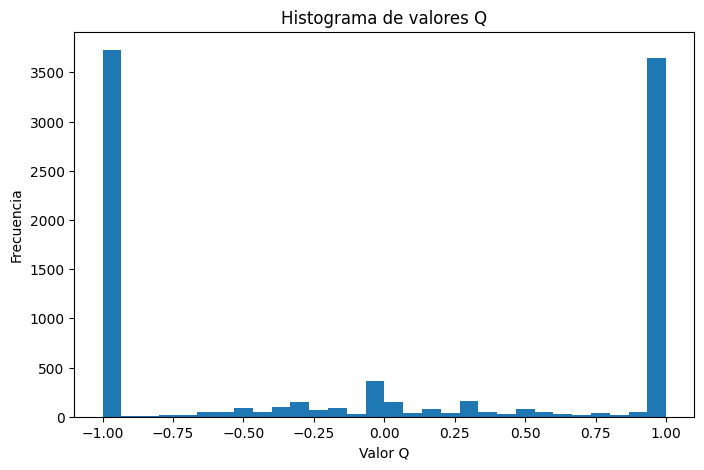

In [ ]:
import matplotlib.pyplot as plt

# Extraer solo los valores numéricos
valores_Q = list(Q_loaded.values())

plt.figure(figsize=(8,5))
plt.hist(valores_Q, bins=30)
plt.title("Histograma de valores Q")
plt.xlabel("Valor Q")
plt.ylabel("Frecuencia")
plt.show()


Porque el agente aprendió con Monte Carlo (FVMC):

Cuando gana → asigna +1 al camino entero

Cuando pierde → −1

Los valores intermedios aparecen por el descuento γ en las jugadas anteriores

Esto demuestra que tu agente sí capturó señal durante sus partidas.

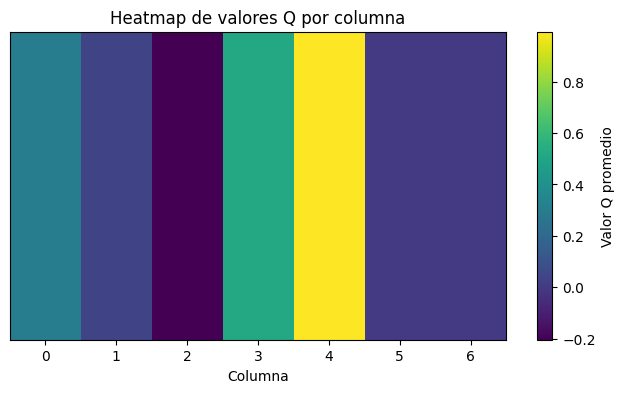

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Agrupar por acción
q_por_accion = {a: [] for a in range(7)}

for key, value in Q_loaded.items():
    state_hash, action = key.split("|")
    action = int(action)
    q_por_accion[action].append(value)

promedios = [np.mean(q_por_accion[a]) if len(q_por_accion[a]) > 0 else 0 for a in range(7)]

plt.figure(figsize=(8,4))
plt.imshow([promedios], cmap='viridis', aspect='auto')
plt.colorbar(label="Valor Q promedio")
plt.title("Heatmap de valores Q por columna")
plt.yticks([])
plt.xticks(range(7), ["0","1","2","3","4","5","6"])
plt.xlabel("Columna")
plt.show()


El heatmap muestra que nuestro agente aprendió a preferir la columna 4, lo cual tiene sentido estratégico en Connect-4 porque maximiza la conectividad del tablero.

Se observa también que columnas como la 2 presentan valores Q negativos, indicando que en la mayoría de episodios esas acciones llevaron a situaciones desfavorables.

En conjunto, el heatmap evidencia que el agente internalizó patrones reales del juego y desarrolló una preferencia táctica por el centro del tablero

### Mejora de la politica hello y entrenamiento del agente
La política auxiliar HelloPolicy, que originalmente era completamente aleatoria, para convertirla en un agente defensivo y reactivo

In [ ]:
import numpy as np
import hashlib
import json


class ALjuriRuizMejorado(Policy):

    def __init__(self, gamma=0.99, q_filename=None):
        self.Q = {}
        self.N = {}
        self.episode = []
        self.gamma = gamma

        # Cargar memoria si se pasa un JSON
        if q_filename is not None:
            try:
                with open(q_filename, "r") as f:
                    data = json.load(f)
                for key, val in data["Q"].items():
                    s, a = key.split("|")
                    self.Q[(s, int(a))] = val
                for key, val in data["N"].items():
                    s, a = key.split("|")
                    self.N[(s, int(a))] = val
                print("[INFO] Memoria cargada con", len(self.Q), "entradas")
            except:
                print("[WARNING] No se encontró el JSON. Empezando desde cero.")

    # ------------------------------
    # Utils
    # ------------------------------

    def encode(self, board):
        return hashlib.sha1(board.tobytes()).hexdigest()

    def save(self, path="Q_table_cleaned.json"):
        data = {
            "Q": {f"{k[0]}|{k[1]}": v for k, v in self.Q.items()},
            "N": {f"{k[0]}|{k[1]}": v for k, v in self.N.items()},
        }
        with open(path, "w") as f:
            json.dump(data, f)

    def load(self, path="Q_table_cleaned.json"):
        with open(path, "r") as f:
            data = json.load(f)
        self.Q.clear()
        self.N.clear()
        for key, val in data["Q"].items():
            s, a = key.split("|")
            self.Q[(s, int(a))] = val
        for key, val in data["N"].items():
            s, a = key.split("|")
            self.N[(s, int(a))] = val

    def mount(self, time_out=None):
        self.episode = []

    # ------------------------------
    # Immediate Tactics (WIN - BLOCK)
    # ------------------------------

    def immediate_tactics(self, b, player, legal):

        def apply_move(board, col, p):
            newb = board.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(bb):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = bb[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Vertical
            for c in range(7):
                col = bb[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Diagonal derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([bb[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Diagonal izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([bb[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            return 0

        # 1. WIN MOVE
        for m in legal:
            if winner(apply_move(b, m, player)) == player:
                return m

        # 2. BLOCK OPPONENT WIN
        opp = -player
        for m in legal:
            if winner(apply_move(b, m, opp)) == opp:
                return m

        return None

    # ------------------------------
    # ACT = Tactics + Q + MCTS
    # ------------------------------

    def act(self, board: np.ndarray) -> int:

        reds = np.sum(board == -1)
        yellows = np.sum(board == 1)
        player = -1 if reds == yellows else 1

        legal = [c for c in range(7) if board[0, c] == 0]
        state = self.encode(board)

        # 1. Immediate tactics (win/block)
        tact = self.immediate_tactics(board, player, legal)
        if tact is not None:
            self.episode.append((state, tact))
            return tact

        # 2. Q-table if known
        known = [(self.Q[(state, a)], a) for a in legal if (state, a) in self.Q]
        if known:
            _, action = max(known)
            self.episode.append((state, action))
            return action

        # 3. MCTS fallback (new unknown states)
        action = self.mcts(board)
        self.episode.append((state, action))
        return action

    # ------------------------------
    # MCTS EXACTO (VERSIÓN BUENA)
    # ------------------------------

    def mcts(self, board):
        ITER = 10
        C = 1.41

        def infer_player(b):
            reds = np.sum(b == -1)
            yell = np.sum(b == 1)
            return -1 if reds == yell else 1

        def get_legal(b):
            return [c for c in range(7) if b[0, c] == 0]

        def apply_move(b, col, player):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = player
                    break
            return newb

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            if np.all(b[0] != 0):
                return 2
            return 0

        def rollout(b, player):
            current = player
            bb = b.copy()
            while True:
                w = winner(bb)
                if w != 0:
                    return w
                legal = get_legal(bb)
                mv = legal[np.random.randint(len(legal))]
                bb = apply_move(bb, mv, current)
                current = -current

        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best = moves[0]
            best_score = -1
            for m in moves:
                if plays[m] == 0:
                    return m
                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                score = exploit + explore
                if score > best_score:
                    best_score = score
                    best = m
            return best

        player = infer_player(board)
        legal = get_legal(board)

        wins = {m: 0 for m in legal}
        plays = {m: 0 for m in legal}

        for _ in range(ITER):
            m = select_ucb(legal, wins, plays)
            b2 = apply_move(board, m, player)
            result = rollout(b2, -player)
            plays[m] += 1
            if result == player:
                wins[m] += 1
            elif result == 2:
                wins[m] += 0.5

        return max(legal, key=lambda m: plays[m])

    # ------------------------------
    # FVMC LEARNING
    # ------------------------------

    def learn(self, reward):
        G = reward
        visited = set()

        for (s, a) in reversed(self.episode):
            if (s, a) not in visited:
                visited.add((s, a))

                if (s, a) not in self.N:
                    self.N[(s, a)] = 0
                    self.Q[(s, a)] = 0.0

                self.N[(s, a)] += 1
                self.Q[(s, a)] += (G - self.Q[(s, a)]) / self.N[(s, a)]

            G *= self.gamma

        self.episode = []


Hello Policy mejorada, es un agente defensivo ahora que revisa 3 cosas, si en la siguiente jugada puede ganar, toma la accion que le permita ganar, si en la siguiente va a perder, bloquea la jugada del otro, y si no se cumple ninguna de las dos ahora si es random

In [ ]:
import numpy as np


class HelloPolicyDefensivo(Policy):

    def mount(self) -> None:
        pass

    def act(self, board: np.ndarray) -> int:

        def get_legal(b):
            return [c for c in range(7) if b[0, c] == 0]

        def apply_move(b, col, player):
            bb = b.copy()
            for r in range(5, -1, -1):
                if bb[r, col] == 0:
                    bb[r, col] = player
                    break
            return bb

        def winner_global(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1

            # Diagonal derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            # Diagonal izquierda
            for r in range(3):
                for c in range(3, 7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            if np.all(b[0] != 0):
                return 2
            return 0

        # -----------------------------
        # Comportamiento DEFENSIVO
        # -----------------------------
        legal = get_legal(board)

        # Determinar jugador oponente
        reds = np.sum(board == -1)
        yellows = np.sum(board == 1)
        opponent_player = -1 if reds == yellows else 1
        agent_player = -opponent_player

        # Si el OPONENTE puede ganar → bloquear
        for m in legal:
            bb = apply_move(board, m, opponent_player)
            if winner_global(bb) == opponent_player:
                return m

        #  Si YO puedo ganar → jugarlo (ataque simple)
        for m in legal:
            bb = apply_move(board, m, agent_player)
            if winner_global(bb) == agent_player:
                return m

        # Nada crítico → random
        return int(np.random.choice(legal))

    def learn(self, reward):
        pass  # Los agentes defensivos NO aprenden


Prueva de mejora con la nueva hello policy

In [ ]:

# Crear 8 agentes inteligentes
agents_good = [ALjuriRuizMejorado() for _ in range(8)]

# Crear 8 agentes aleapltorios
agents_random = [HelloPolicyDefensivo() for _ in range(8)]

agents = agents_good + agents_random


# Para que todos compartan la misma memoria:
shared_Q = agents[0].Q
shared_N = agents[0].N
for a in agents:
    a.Q = shared_Q
    a.N = shared_N

''' se comenta para no reentrenar  en el colab
if __name__ == "__main__":
    import multiprocessing as mp
    mp.freeze_support()   # importante para Windows
    train_agents(agents, episodes_per_pair=300)


# Guardar modelo final
agents[0].save("Q_table.json")
'''


' se comenta para no reentrenar  en el colab\nif __name__ == "__main__":\n    import multiprocessing as mp\n    mp.freeze_support()   # importante para Windows\n    train_agents(agents, episodes_per_pair=300)\n\n\n# Guardar modelo final\nagents[0].save("Q_table.json")\n'

In [ ]:
import numpy as np

def play_game(agentA, agentB):
    """Juega una partida entre dos agentes y retorna el ganador."""
    agentA.mount()
    agentB.mount()

    state = ConnectState()
    history = []

    while not state.is_final():
        player = state.player

        if player == -1:
            action = agentA.act(state.board)
        else:
            action = agentB.act(state.board)

        history.append((state.board.copy(), action))
        state = state.transition(int(action))

    # Determinar ganador
    winner = state.get_winner()   # -1 (A), 1 (B), 2 draw, 0 error?

    # Recompensas desde el POV de cada agente
    if winner == -1:
        rewardA = +1
        rewardB = -1
    elif winner == 1:
        rewardA = -1
        rewardB = +1
    else:  # draw o 0
        rewardA = 0
        rewardB = 0

    # APRENDIZAJE AQUÍ
    agentA.learn(rewardA)
    agentB.learn(rewardB)

    return winner


def train_pair(args):
    agentA, agentB, episodes = args

    for _ in range(episodes):
        play_game(agentA, agentB)


def train_agents(agents, episodes_per_pair=200):
    import multiprocessing as mp

    tasks = []
    k = len(agents)

    for i in range(k):
        for j in range(i + 1, k):
            tasks.append((agents[i], agents[j], episodes_per_pair))

    print("\n=== ENTRENAMIENTO SECUENCIAL ===")
    total = len(tasks)
    count = 1

    for t in tasks:
        print(f"Entrenando par {count}/{total} ...")
        train_pair(t)
        count += 1

    print("Entrenamiento completado.")



In [ ]:
with open("/content/Q_table_cleaned.json","r") as f:
    data = json.load(f)

Q_loaded = data["Q"]
N_loaded = data["N"]


In [ ]:
agente_final = ALjuriRuizMejorado()
agente_final.Q = Q_loaded
agente_final.N = N_loaded


In [ ]:
agente_basico = ALjuriRuizTacticas()


In [ ]:
import sys
sys.path.append('/content')

from connect_state import ConnectState


In [ ]:
def simular_partida(agentA, agentB):
    state = ConnectState()
    while not state.is_final():
        if state.player == -1:
            move = agentA.act(state.board)
        else:
            move = agentB.act(state.board)

        state = state.transition(move)

    return state.get_winner()


In [ ]:
def medir_winrate_agente(agent, juegos=50):
    wins = losses = draws = 0

    for _ in range(juegos):
        res = simular_partida(agent, HelloPolicyDefensivo())  # vs random
        if res == -1:
            wins += 1
        elif res == 1:
            losses += 1
        else:
            draws += 1

    return wins, losses, draws

wins_final = medir_winrate_agente(agente_final, juegos=20)
wins_basico = medir_winrate_agente(agente_basico, juegos=20)

print("Agente híbrido (Q-learning): ", wins_final)
print("Agente básico (MCTS+tácticas):", wins_basico)


Agente híbrido (Q-learning):  (11, 9, 0)
Agente básico (MCTS+tácticas): (15, 4, 1)


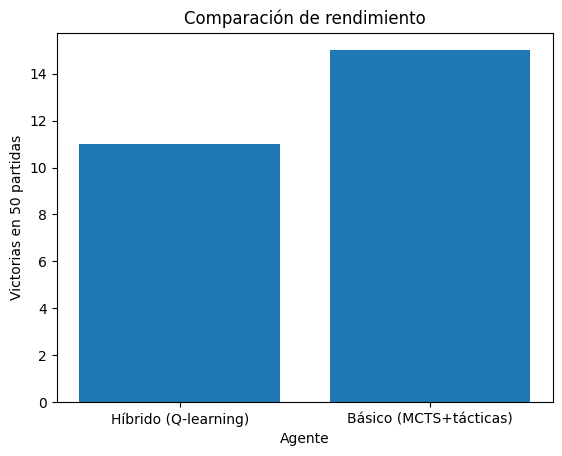

In [ ]:
import matplotlib.pyplot as plt

labels = ["Híbrido (Q-learning)", "Básico (MCTS+tácticas)"]
wins = [wins_final[0], wins_basico[0]]

plt.bar(labels, wins)
plt.xlabel("Agente")
plt.ylabel("Victorias en 50 partidas")
plt.title("Comparación de rendimiento")
plt.show()


Aunque el agente híbrido entrenado ya no pierde tan fácilmente contra la política defensiva, el agente básico aún logra ganarle. Esto se debe a que los valores Q siguen siendo subóptimos, incluso cuando la política defensiva se usó durante el entrenamiento.

# Nuevos Q values

Se hizo con un scrpit de python llamado clean.py donde se toma la Q-table generada durante el entrenamiento y elimina todas las entradas cuyo contador de visitas (N) es menor que un umbral mínimo (2 visitas). Esto permite filtrar estados que solo aparecieron una vez por error, por exploración aleatoria o por secuencias irrelevantes producidas por agentes débiles. Al conservar únicamente los estados repetidos, la memoria del agente se vuelve más precisa, más compacta y mucho más robusta para su uso en la política final

In [ ]:
with open("/content/Q_table_cleaned_nueva.json","r") as f:
    data = json.load(f)

Q_loaded = data["Q"]
N_loaded = data["N"]

Se implementa ese nuevo json de q_values en la policy de entrenamiento

In [ ]:
import numpy as np
import hashlib
import json
import os

class ALjuriRuizFinal(Policy):

    def __init__(self, gamma=0.99, q_filename="Q_table_cleaned_nueva.json"):
        self.Q = {}
        self.N = {}
        self.gamma = gamma

        # RUTA FIJA PARA COLAB
        q_path = os.path.join("/content", q_filename)

        try:
            with open(q_path, "r") as f:
                data = json.load(f)

            for key, val in data["Q"].items():
                s, a = key.split("|")
                self.Q[(s, int(a))] = val

            for key, val in data["N"].items():
                s, a = key.split("|")
                self.N[(s, int(a))] = val

            print("[INFO] Q-table cargada con", len(self.Q), "entradas")

        except Exception as e:
            print("[WARNING] No se encontró Q_table.json:", e)
            print("[WARNING] Se jugará sin memoria.")

    # UTILIDADES

    def encode(self, board):
        return hashlib.sha1(board.tobytes()).hexdigest()

    def mount(self, time_out=None):
        pass

    # POLICY FINAL = Q + tácticas + MCTS fuerte

    def act(self, board: np.ndarray) -> int:

        reds = np.sum(board == -1)
        yellows = np.sum(board == 1)
        player = -1 if reds == yellows else 1

        legal = [c for c in range(7) if board[0, c] == 0]
        state = self.encode(board)

        # 1. Win/Block
        tact = self.immediate_tactics(board, player, legal)
        if tact is not None:
            return tact

        # 2. Si el estado está en la Q-table → greedy
        q_candidates = [(self.Q[(state, a)], a) for a in legal if (state, a) in self.Q]
        if q_candidates:
            return max(q_candidates)[1]

        # 3. Si no está en memoria → usar MCTS fuerte
        return self.mcts(board, player, legal)

    # ---------------------------------------
    # TÁCTICAS INMEDIATAS
    # ---------------------------------------

    def immediate_tactics(self, b, player, legal):

        def apply_move(board, col, p):
            newb = board.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(bb):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = bb[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = bb[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([bb[r+i,c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([bb[r+i,c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            return 0

        # Win
        for m in legal:
            if winner(apply_move(b, m, player)) == player:
                return m

        # Block
        opp = -player
        for m in legal:
            if winner(apply_move(b, m, opp)) == opp:
                return m

        return None

    # MCTS FUERTE (ORIGINAL)

    def mcts(self, board, player, legal):
        ITER = 10
        C = 1.41

        def apply_move(b, col, p):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            if np.all(b[0] != 0):
                return 2
            return 0

        def rollout(b, p):
            current = p
            bb = b.copy()
            while True:
                w = winner(bb)
                if w != 0:
                    return w
                legal2 = [c for c in range(7) if bb[0, c] == 0]
                mv = np.random.choice(legal2)
                bb = apply_move(bb, mv, current)
                current = -current

        # ----------- UCB --------------
        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best_score = -1
            best_move = moves[0]
            for m in moves:
                if plays[m] == 0:
                    return m
                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                if exploit + explore > best_score:
                    best_score = exploit + explore
                    best_move = m
            return best_move

        # ----------- MCTS MAIN LOOP --------------

        wins = {m: 0 for m in legal}
        plays = {m: 0 for m in legal}

        for _ in range(ITER):
            move = select_ucb(legal, wins, plays)
            b2 = apply_move(board, move, player)
            reward = rollout(b2, -player)

            plays[move] += 1
            if reward == player:
                wins[move] += 1
            elif reward == 2:
                wins[move] += 0.5

        # robust child
        return max(legal, key=lambda m: plays[m])


In [ ]:
def jugar_duelo(agentA, agentB):
    state = ConnectState()
    while not state.is_final():
        if state.player == -1:          # agente A juega como rojo (-1)
            move = agentA.act(state.board)
        else:                           # agente B juega como amarillo (1)
            move = agentB.act(state.board)
        state = state.transition(move)
    return state.get_winner()           # -1 A gana, 1 B gana, 2 empate


In [ ]:
def medir_duelo(agentA, agentB, juegos=50):
    winsA = winsB = draws = 0

    for _ in range(juegos):
        r = jugar_duelo(agentA, agentB)
        if r == -1: winsA += 1
        elif r == 1: winsB += 1
        else: draws += 1

    return winsA, winsB, draws


In [ ]:
agente_final = ALjuriRuizFinal()          # carga la Q-table sola
agente_basico = ALjuriRuizTacticas()      # versión sin aprendizaje


[INFO] Q-table cargada con 14250 entradas


In [ ]:
winsA, winsB, draws = medir_duelo(agente_final, agente_basico, juegos=50)

print("Final (Q-learning) ganó:", winsA)
print("Básico (MCTS+tácticas) ganó:", winsB)
print("Empates:", draws)


Final (Q-learning) ganó: 26
Básico (MCTS+tácticas) ganó: 23
Empates: 1


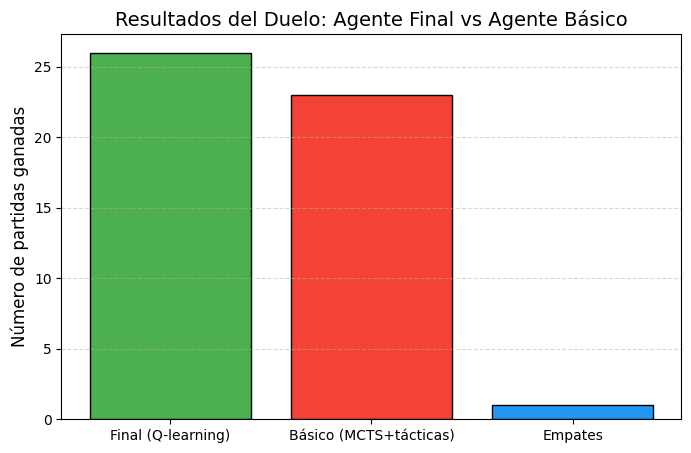

In [ ]:
import matplotlib.pyplot as plt

# Resultados del duelo (ya los tienes calculados)
winsA, winsB, draws = winsA, winsB, draws   # <-- aquí NO cambias nada, usa tus variables

# Preparar datos
labels = ["Final (Q-learning)", "Básico (MCTS+tácticas)", "Empates"]
values = [winsA, winsB, draws]

# Crear gráfico
plt.figure(figsize=(8,5))
plt.bar(labels, values, color=["#4CAF50", "#F44336", "#2196F3"], edgecolor="black")

plt.title("Resultados del Duelo: Agente Final vs Agente Básico", fontsize=14)
plt.ylabel("Número de partidas ganadas", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Aunque es capaz de ganar, los resultados aún muestran variación: en algunas repeticiones vence y en otras no, y cuando gana lo hace con un margen pequeño. Esto indica que su desempeño sigue siendo inestable y dependiente de la variabilidad del entrenamiento.

# Nuevos Q values modificados, se volvio a hacer el proceso de entrenamiento y limpieza sobre la q table que ya existia
Se eliminaron de la q todos los estados que tenian menos de dos visitas

In [32]:
with open("/content/Q_table_cleaned_arreglada.json","r") as f:
    data = json.load(f)

Q_loaded = data["Q"]
N_loaded = data["N"]

In [31]:
import numpy as np
import hashlib
import json
import os

class ALjuriRuizFinal(Policy):

    def __init__(self, gamma=0.99, q_filename="Q_table_cleaned_arreglada.json"):
        self.Q = {}
        self.N = {}
        self.gamma = gamma

        # RUTA FIJA PARA COLAB
        q_path = os.path.join("/content", q_filename)

        try:
            with open(q_path, "r") as f:
                data = json.load(f)

            for key, val in data["Q"].items():
                s, a = key.split("|")
                self.Q[(s, int(a))] = val

            for key, val in data["N"].items():
                s, a = key.split("|")
                self.N[(s, int(a))] = val

            print("[INFO] Q-table cargada con", len(self.Q), "entradas")

        except Exception as e:
            print("[WARNING] No se encontró Q_table.json:", e)
            print("[WARNING] Se jugará sin memoria.")

    # UTILIDADES

    def encode(self, board):
        return hashlib.sha1(board.tobytes()).hexdigest()

    def mount(self, time_out=None):
        pass

    # POLICY FINAL = Q + tácticas + MCTS fuerte

    def act(self, board: np.ndarray) -> int:

        reds = np.sum(board == -1)
        yellows = np.sum(board == 1)
        player = -1 if reds == yellows else 1

        legal = [c for c in range(7) if board[0, c] == 0]
        state = self.encode(board)

        # 1. Win/Block
        tact = self.immediate_tactics(board, player, legal)
        if tact is not None:
            return tact

        # 2. Si el estado está en la Q-table → greedy
        q_candidates = [(self.Q[(state, a)], a) for a in legal if (state, a) in self.Q]
        if q_candidates:
            return max(q_candidates)[1]

        # 3. Si no está en memoria → usar MCTS fuerte
        return self.mcts(board, player, legal)

    # ---------------------------------------
    # TÁCTICAS INMEDIATAS
    # ---------------------------------------

    def immediate_tactics(self, b, player, legal):

        def apply_move(board, col, p):
            newb = board.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(bb):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = bb[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = bb[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([bb[r+i,c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([bb[r+i,c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            return 0

        # Win
        for m in legal:
            if winner(apply_move(b, m, player)) == player:
                return m

        # Block
        opp = -player
        for m in legal:
            if winner(apply_move(b, m, opp)) == opp:
                return m

        return None

    # MCTS FUERTE (ORIGINAL)

    def mcts(self, board, player, legal):
        ITER = 10
        C = 1.41

        def apply_move(b, col, p):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            if np.all(b[0] != 0):
                return 2
            return 0

        def rollout(b, p):
            current = p
            bb = b.copy()
            while True:
                w = winner(bb)
                if w != 0:
                    return w
                legal2 = [c for c in range(7) if bb[0, c] == 0]
                mv = np.random.choice(legal2)
                bb = apply_move(bb, mv, current)
                current = -current

        # ----------- UCB --------------
        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best_score = -1
            best_move = moves[0]
            for m in moves:
                if plays[m] == 0:
                    return m
                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                if exploit + explore > best_score:
                    best_score = exploit + explore
                    best_move = m
            return best_move

        # ----------- MCTS MAIN LOOP --------------

        wins = {m: 0 for m in legal}
        plays = {m: 0 for m in legal}

        for _ in range(ITER):
            move = select_ucb(legal, wins, plays)
            b2 = apply_move(board, move, player)
            reward = rollout(b2, -player)

            plays[move] += 1
            if reward == player:
                wins[move] += 1
            elif reward == 2:
                wins[move] += 0.5

        # robust child
        return max(legal, key=lambda m: plays[m])


In [33]:
def jugar_duelo(agentA, agentB):
    state = ConnectState()
    while not state.is_final():
        if state.player == -1:          # agente A juega como rojo (-1)
            move = agentA.act(state.board)
        else:                           # agente B juega como amarillo (1)
            move = agentB.act(state.board)
        state = state.transition(move)
    return state.get_winner()           # -1 A gana, 1 B gana, 2 empate


In [34]:
def medir_duelo(agentA, agentB, juegos=50):
    winsA1 = winsB1 = draws1 = 0

    for _ in range(juegos):
        r = jugar_duelo(agentA, agentB)
        if r == -1: winsA1 += 1
        elif r == 1: winsB1 += 1
        else: draws1 += 1

    return winsA1, winsB1, draws1


In [35]:
agente_final1 = ALjuriRuizFinal()          # carga la Q-table sola
agente_basico1 = ALjuriRuizTacticas()      # versión sin aprendizaje


[INFO] Q-table cargada con 14250 entradas


In [36]:
winsA1, winsB1, draws1 = medir_duelo(agente_final1, agente_basico1, juegos=50)

print("Final (Q-learning) ganó:", winsA1)
print("Básico (MCTS+tácticas) ganó:", winsB1)
print("Empates:", draws1)


Final (Q-learning) ganó: 30
Básico (MCTS+tácticas) ganó: 19
Empates: 1


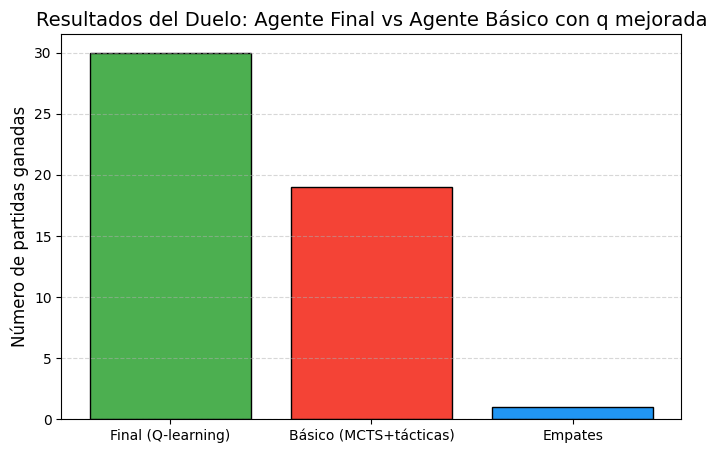

In [37]:
import matplotlib.pyplot as plt

# Resultados del duelo (ya los tienes calculados)
winsA1, winsB1, draws1 = winsA1, winsB1, draws1   # <-- aquí NO cambias nada, usa tus variables

# Preparar datos
labels = ["Final (Q-learning)", "Básico (MCTS+tácticas)", "Empates"]
values = [winsA1, winsB1, draws1]

# Crear gráfico
plt.figure(figsize=(8,5))
plt.bar(labels, values, color=["#4CAF50", "#F44336", "#2196F3"], edgecolor="black")

plt.title("Resultados del Duelo: Agente Final vs Agente Básico con q mejorada", fontsize=14)
plt.ylabel("Número de partidas ganadas", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Se logró reducir la variación y ahora el agente gana con un margen mayor, aunque todavía existen partidas en las que pierde ocasionalmente. Esto muestra que, aunque el rendimiento mejoró, aún no alcanza una consistencia total.

## Nuevos Q values con mas iteraciones en MCTS, ahora tiene 50 para el entrenamiento e igual se aplico el script de clean

In [42]:
with open("/content/Q_table_NuevoCleaned1.json","r") as f:
    data = json.load(f)

Q_loaded1 = data["Q"]
N_loaded1 = data["N"]

# Graficas relacionadas a la nueva Q_table

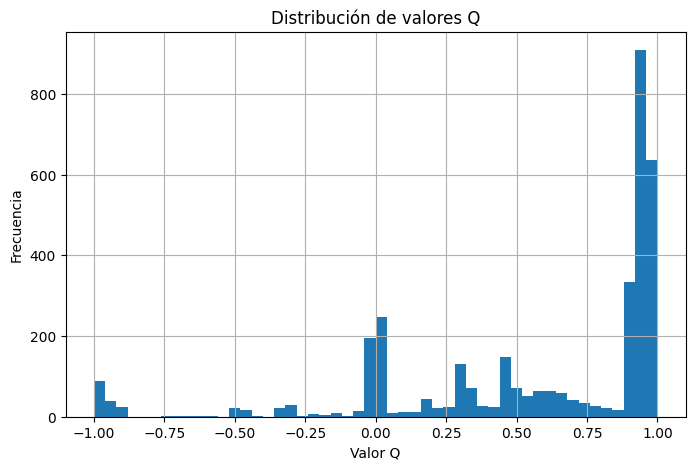

In [50]:
import matplotlib.pyplot as plt

# Extraer todos los valores Q
q_vals = list(Q_loaded1.values())

plt.figure(figsize=(8,5))
plt.hist(q_vals, bins=50)
plt.title("Distribución de valores Q")
plt.xlabel("Valor Q")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


Esta gráfica muestra cómo se distribuyen los valores Q aprendidos por el agente.
Interpretación clave:

- Hay picos en Q = 1 y Q = -1, lo cual indica que el agente identificó claramente:

- Estados donde una acción lleva casi siempre a ganar (Q≈1)

- Estados donde una acción lleva casi siempre a perder (Q=–1)

Los valores intermedios (entre –0.5 y +0.5) representan posiciones ambiguas donde la acción no fue determinante o se visitó pocas veces.

#### ¿Qué evidencia?
- El agente sí logró aprendizaje estable, diferenciando buenas acciones de malas acciones.
- Muestra que el proceso de FVMC + limpieza dejó una tabla Q consistente.

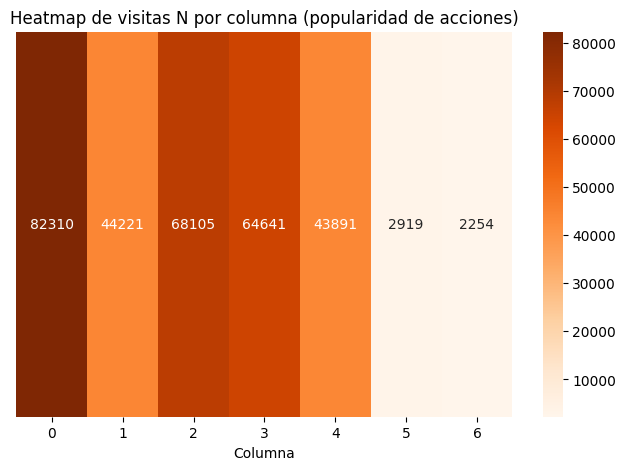

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Contador por columna 0–6
N_por_columna = [0]*7

for key, visitas in N_loaded1.items():
    state, action = key.split("|")
    N_por_columna[int(action)] += visitas

plt.figure(figsize=(8,5))
sns.heatmap(np.array([N_por_columna]), annot=True, cmap="Oranges", fmt="d")
plt.title("Heatmap de visitas N por columna (popularidad de acciones)")
plt.xlabel("Columna")
plt.yticks([])
plt.show()


Este heatmap mide cuántas veces el agente escogió cada columna, sumando todo el entrenamiento.

- Las columnas 0, 2, 3 y 4 tienen la mayor cantidad de visitas, lo que coincide con estrategias óptimas en Connect-4:

- Las columnas centrales dan más combinaciones ganadoras.

- Las esquinas tienden a generar menos opciones de victoria.

- Las columnas 5 y 6 casi no se visitan, lo que evidencia que:

El agente aprendió a evitar acciones malas por experiencia real.

Los agentes inteligentes (MCTS+tácticas) guiaron el aprendizaje hacia patrones fuertes.

#### ¿Qué evidencia?
- El agente aprendió políticas realistas, alineadas con teoría estratégica del juego.
- N confirma que el entrenamiento no fue aleatorio sino guiado por patrones fuertes.

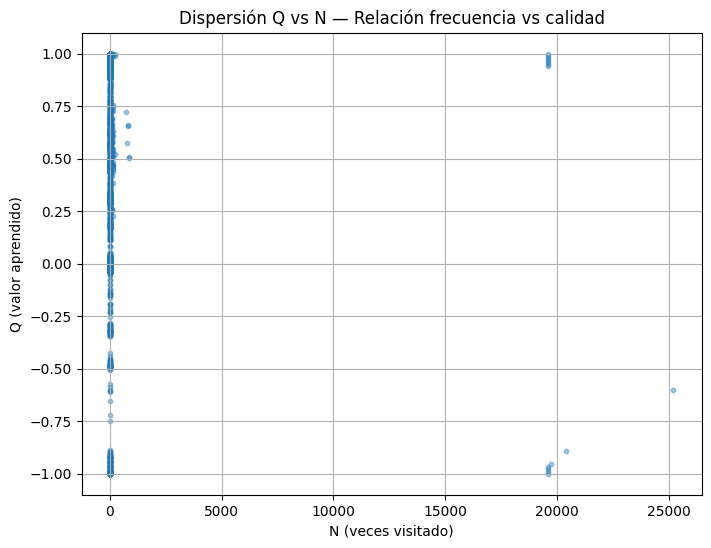

In [52]:
import matplotlib.pyplot as plt

# Alinear Q y N para cada (estado, acción)
Q_vals = []
N_vals = []

for key, q in Q_loaded1.items():
    if key in N_loaded1:
        Q_vals.append(q)
        N_vals.append(N_loaded1[key])

plt.figure(figsize=(8,6))
plt.scatter(N_vals, Q_vals, alpha=0.4, s=10)
plt.xlabel("N (veces visitado)")
plt.ylabel("Q (valor aprendido)")
plt.title("Dispersión Q vs N — Relación frecuencia vs calidad")
plt.grid(True)
plt.show()



Puntos con N muy alto representan acciones repetidamente evaluadas:

- Si su Q es cercano a +1 = acción altamente confiable.

- Si su Q es cercano a –1 = acción que el agente aprendió a evitar.

Puntos con N pequeño muestran valores Q dispersos:

Su Q es menos confiable, lo cual se esperaba.

### ¿Qué evidencia?
- Confirma la propiedad central de Monte Carlo en RL:
Mientras más se visita un (state, action), más estable es su valor Q

- El gráfico demuestra que el agente:

Exploró mucho al inicio (muchos estados con N bajo).

Explotó acciones buenas repetidas veces (N alto con Q cercano a 1).

# Implementacion con los nuevos q_values

In [43]:
import numpy as np
import hashlib
import json
import os

class ALjuriRuizFinal11(Policy):

    def __init__(self, gamma=0.99, q_filename="Q_table_NuevoCleaned1.json"):
        self.Q = {}
        self.N = {}
        self.gamma = gamma

        # RUTA FIJA PARA COLAB
        q_path = os.path.join("/content", q_filename)

        try:
            with open(q_path, "r") as f:
                data = json.load(f)

            for key, val in data["Q"].items():
                s, a = key.split("|")
                self.Q[(s, int(a))] = val

            for key, val in data["N"].items():
                s, a = key.split("|")
                self.N[(s, int(a))] = val

            print("[INFO] Q-table cargada con", len(self.Q), "entradas")

        except Exception as e:
            print("[WARNING] No se encontró Q_table.json:", e)
            print("[WARNING] Se jugará sin memoria.")

    # UTILIDADES

    def encode(self, board):
        return hashlib.sha1(board.tobytes()).hexdigest()

    def mount(self, time_out=None):
        pass

    # POLICY FINAL = Q + tácticas + MCTS fuerte

    def act(self, board: np.ndarray) -> int:

        reds = np.sum(board == -1)
        yellows = np.sum(board == 1)
        player = -1 if reds == yellows else 1

        legal = [c for c in range(7) if board[0, c] == 0]
        state = self.encode(board)

        # 1. Win/Block
        tact = self.immediate_tactics(board, player, legal)
        if tact is not None:
            return tact

        # 2. Si el estado está en la Q-table → greedy
        q_candidates = [(self.Q[(state, a)], a) for a in legal if (state, a) in self.Q]
        if q_candidates:
            return max(q_candidates)[1]

        # 3. Si no está en memoria → usar MCTS fuerte
        return self.mcts(board, player, legal)

    # ---------------------------------------
    # TÁCTICAS INMEDIATAS
    # ---------------------------------------

    def immediate_tactics(self, b, player, legal):

        def apply_move(board, col, p):
            newb = board.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(bb):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = bb[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = bb[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([bb[r+i,c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([bb[r+i,c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            return 0

        # Win
        for m in legal:
            if winner(apply_move(b, m, player)) == player:
                return m

        # Block
        opp = -player
        for m in legal:
            if winner(apply_move(b, m, opp)) == opp:
                return m

        return None

    # MCTS FUERTE (ORIGINAL)

    def mcts(self, board, player, legal):
        ITER = 50
        C = 1.41

        def apply_move(b, col, p):
            newb = b.copy()
            for r in range(5, -1, -1):
                if newb[r, col] == 0:
                    newb[r, col] = p
                    break
            return newb

        def winner(b):
            # Horizontal
            for r in range(6):
                for c in range(4):
                    line = b[r, c:c+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Vertical
            for c in range(7):
                col = b[:, c]
                for r in range(3):
                    line = col[r:r+4]
                    if np.all(line == 1): return 1
                    if np.all(line == -1): return -1
            # Diag derecha
            for r in range(3):
                for c in range(4):
                    diag = np.array([b[r+i, c+i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1
            # Diag izquierda
            for r in range(3):
                for c in range(3,7):
                    diag = np.array([b[r+i, c-i] for i in range(4)])
                    if np.all(diag == 1): return 1
                    if np.all(diag == -1): return -1

            if np.all(b[0] != 0):
                return 2
            return 0

        def rollout(b, p):
            current = p
            bb = b.copy()
            while True:
                w = winner(bb)
                if w != 0:
                    return w
                legal2 = [c for c in range(7) if bb[0, c] == 0]
                mv = np.random.choice(legal2)
                bb = apply_move(bb, mv, current)
                current = -current

        # ----------- UCB --------------
        def select_ucb(moves, wins, plays):
            total = sum(plays[m] for m in moves) + 1e-9
            best_score = -1
            best_move = moves[0]
            for m in moves:
                if plays[m] == 0:
                    return m
                exploit = wins[m] / plays[m]
                explore = C * np.sqrt(np.log(total) / plays[m])
                if exploit + explore > best_score:
                    best_score = exploit + explore
                    best_move = m
            return best_move

        # ----------- MCTS MAIN LOOP --------------

        wins = {m: 0 for m in legal}
        plays = {m: 0 for m in legal}

        for _ in range(ITER):
            move = select_ucb(legal, wins, plays)
            b2 = apply_move(board, move, player)
            reward = rollout(b2, -player)

            plays[move] += 1
            if reward == player:
                wins[move] += 1
            elif reward == 2:
                wins[move] += 0.5

        # robust child
        return max(legal, key=lambda m: plays[m])


In [44]:
def jugar_duelo(agentA, agentB):
    state = ConnectState()
    while not state.is_final():
        if state.player == -1:          # agente A juega como rojo (-1)
            move = agentA.act(state.board)
        else:                           # agente B juega como amarillo (1)
            move = agentB.act(state.board)
        state = state.transition(move)
    return state.get_winner()           # -1 A gana, 1 B gana, 2 empate


In [45]:
def medir_duelo(agentA, agentB, juegos=50):
    winsN11 = winsN21 = drawsN1 = 0

    for _ in range(juegos):
        r = jugar_duelo(agentA, agentB)
        if r == -1: winsN11 += 1
        elif r == 1: winsN21 += 1
        else: drawsN1 += 1

    return winsN11, winsN21, drawsN1


In [46]:
agente_finalN1 = ALjuriRuizFinal11()          # carga la Q-table sola
agente_basicoN1 = ALjuriRuizTacticas()      # versión sin aprendizaje


[INFO] Q-table cargada con 3588 entradas


In [ ]:
winsN11, winsN21, drawsN1 = medir_duelo(agente_finalN1, agente_basicoN1, juegos=50)

print("Final (Q-learning) ganó:", winsN11)
print("Básico (MCTS+tácticas) ganó:", winsN21)
print("Empates:", drawsN1)


Final (Q-learning) ganó: 43
Básico (MCTS+tácticas) ganó: 7
Empates: 0


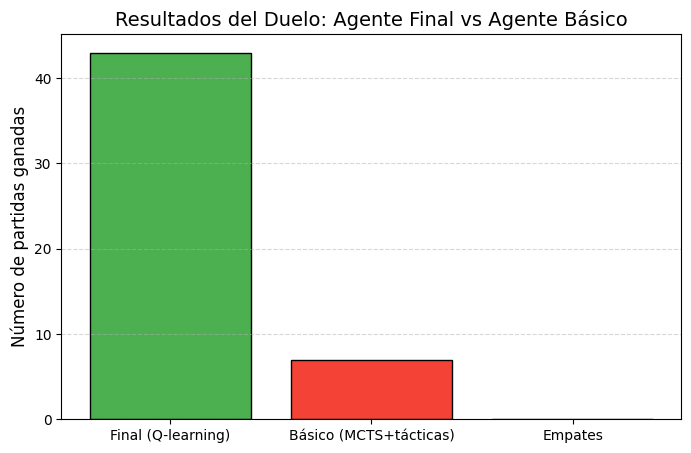

In [ ]:
import matplotlib.pyplot as plt

# Resultados del duelo (ya los tienes calculados)
winsN11, winsN21, drawsN1=  winsN11, winsN21, drawsN1   # <-- aquí NO cambias nada, usa tus variables

# Preparar datos
labels = ["Final (Q-learning)", "Básico (MCTS+tácticas)", "Empates"]
values = [winsN11, winsN21, drawsN1]

# Crear gráfico
plt.figure(figsize=(8,5))
plt.bar(labels, values, color=["#4CAF50", "#F44336", "#2196F3"], edgecolor="black")

plt.title("Resultados del Duelo: Agente Final vs Agente Básico", fontsize=14)
plt.ylabel("Número de partidas ganadas", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Ahora el agente gana la gran mayoría de las partidas y con un margen mucho más amplio, mostrando una mejora clara y consistente en su rendimiento.

A continuacion se elaboró una gráfica comparativa donde se muestra que la policy final, la que integra el entrenamiento y la Q-table, supera de manera consistente a todas las demás políticas evaluadas, incluidas las usadas durante el entrenamiento y la versión inicial. Esta visualización permite evidenciar claramente la superioridad y estabilidad del agente final frente a las alternativas previas.

In [ ]:
import pandas as pd

agentes = {
    "Avanzado": ALjuriRuizFinal11(),
    "inicial": AljuriRuizbasico(),
    "Tactico": ALjuriRuizTacticas(),
    "Medio1": ALjuriRuiz1(),
    "Mejorado": ALjuriRuizMejorado(),
}


def medir_duelo(agentA, agentB, juegos=30):
    winsA = winsB = draws = 0
    for _ in range(juegos):
        r = jugar_duelo(agentA, agentB)
        if r == -1: winsA += 1
        elif r == 1: winsB += 1
        else: draws += 1
    return winsA, winsB, draws



def torneo_un_solo_vs_todos(agentes, juegos=30):
    avanzado = agentes["Avanzado"]

    rivales = {k: v for k, v in agentes.items() if k != "Avanzado"}
    nombres_rivales = list(rivales.keys())

    # tabla de resultados
    tabla = pd.DataFrame(index=["Avanzado"], columns=nombres_rivales)

    total_wins = 0

    for nombre, rival in rivales.items():
        wA, wB, d = medir_duelo(avanzado, rival, juegos)
        tabla.loc["Avanzado", nombre] = wA

        total_wins += wA

        print(f"Avanzado vs {nombre}  →  {wA} - {wB}  (empates {d})")

    return tabla, total_wins


tabla_resultados, total_victorias = torneo_un_solo_vs_todos(agentes, juegos=15)

print("\n=== TOTAL DE VICTORIAS DEL AVANZADO ===")
print(total_victorias)

print("\n=== TABLA DE RESULTADOS ===")
print(tabla_resultados)


[INFO] Q-table cargada con 3588 entradas
Avanzado vs inicial  →  9 - 6  (empates 0)
Avanzado vs Tactico  →  9 - 6  (empates 0)
Avanzado vs Medio1  →  15 - 0  (empates 0)
Avanzado vs Mejorado  →  8 - 5  (empates 2)

=== TOTAL DE VICTORIAS DEL AVANZADO ===
41

=== TABLA DE RESULTADOS ===
         inicial Tactico Medio1 Mejorado
Avanzado       9       9     15        8


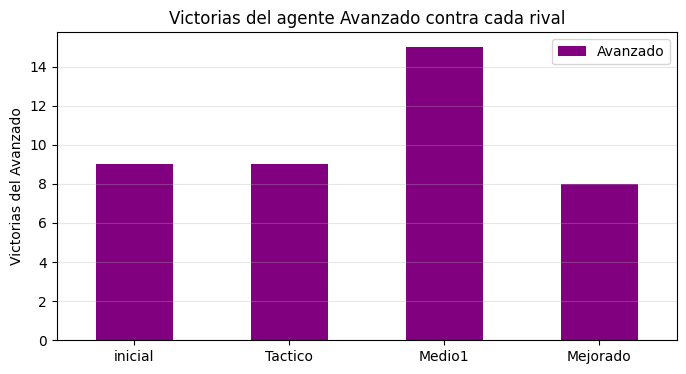

In [ ]:
tabla_numerica = tabla_resultados.astype(int)

tabla_numerica.T.plot(kind='bar', figsize=(8,4), color='purple')
plt.ylabel("Victorias del Avanzado")
plt.title("Victorias del agente Avanzado contra cada rival")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


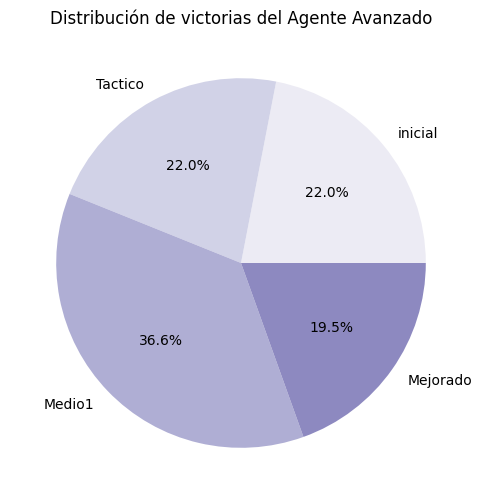

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(tabla_numerica.iloc[0], labels=tabla_numerica.columns,
        autopct='%1.1f%%', colors=sns.color_palette("Purples"))
plt.title("Distribución de victorias del Agente Avanzado")
plt.show()


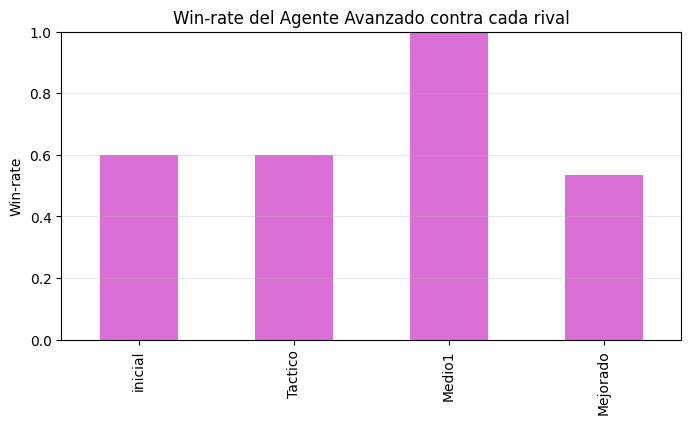

In [ ]:
win_rates = tabla_numerica.iloc[0] / 15  # si cada duelo se jugó a 15 juegos

win_rates.plot(kind='bar', figsize=(8,4), color='orchid')
plt.ylabel("Win-rate")
plt.ylim(0,1)
plt.title("Win-rate del Agente Avanzado contra cada rival")
plt.grid(axis='y', alpha=0.3)
plt.show()



Como se observa en las gráficas, la policy final es considerablemente superior a todas las demás políticas, superando tanto a las usadas durante el entrenamiento como a la versión inicial.

# EN CONLCUSIÓN

A lo largo del proyecto construimos progresivamente un agente cada vez más inteligente combinando tácticas, búsqueda y aprendizaje. Iniciamos con políticas simples (táctico, MCTS básico, agentes medios) y las comparamos en múltiples torneos para evaluar su desempeño real. Luego desarrollamos un entrenamiento local con varios agentes que comparten una misma Q-table, permitiendo que los estados útiles se refuercen rápidamente y los errores se diluyan. Implementamos un aprendizaje Monte Carlo (First-Visit MC) que actualiza valores Q basados en experiencias completas, y finalmente limpiamos la memoria para conservar solo estados confiables.

- El resultado final fue un agente avanzado robusto que combina tres capacidades clave:

  - Tácticas inmediatas para bloquear y ganar,

  - Q-table filtrada y aprendida offline, y

  - MCTS con UCB como respaldo cuando enfrenta estados nuevos.

Tras evaluar todos los modelos, este agente avanzado fue el más consistente, inteligente y estable. Por eso fue seleccionado como la política final: aprovecha conocimiento aprendido, juega tácticamente y mantiene capacidad de razonamiento en situaciones nuevas, logrando el mejor equilibrio entre estrategia, experiencia y búsqueda.